# Openset learning demo

Most is based on the paper:

Vaze, S., Han, K., Vedaldi, A. & Zisserman, A. Open-Set Recognition: a Good Closed-Set Classifier is All You Need? arXiv (2021) doi:10.48550/arxiv.2110.06207.

An important point is how to **organize the datasets and the models**:
$$D_{train} = \{(\vec{x_i}, y_i)\}_{i=1}^N \subset X \times C \text{, with } Model(\vec{x_i}) = p(y_i | \vec{x_i})$$
$$D_{test-closed} = \{(\vec{x_i}, y_i)\}_{i=1}^M \subset X \times C \text{, with } Model(\vec{x_i}) = p(y_i | \vec{x_i})$$
$$D_{test-open} = \{(\vec{x_i}, y_i)\}_{i=1}^{M'} \subset X \times (C \cup U) \text{, with } Model(\vec{x_i}) = (p(y_i | \vec{x_i}), S(y_i \subset C | \vec{x_i}))$$

It is trivial how to evaluate the `train` and `test-closed` scenarios.

First, let's pick the NDB1 problem and a positive and negative antigen.

In [1]:
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import optuna
import mlflow

import NegativeClassOptimization.utils as utils
import NegativeClassOptimization.config as config
import NegativeClassOptimization.preprocessing as preprocessing
import NegativeClassOptimization.ml as ml
import NegativeClassOptimization.visualisations as vis

/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The closed-set loop allows to train a model that outputs logits and expits (probability estimations). We will leverage that later for the openset scenario.

In [9]:
N = 1000

epochs = 2
learning_rate = 0.01
ag_pos = "1FBI"
# ag_neg = "1NSN"
ag_neg = ["1NSN", "1OB1"]  # for NDBK

data_path = Path(config.DATA_SLACK_1_GLOBAL)

In [10]:
processed_dfs: dict = utils.load_processed_dataframes()
df_train_val = processed_dfs["train_val"]
df_train_val = df_train_val.loc[df_train_val["Antigen"].isin([ag_pos, *ag_neg])]
df_test_closed = processed_dfs["test_closed_exclusive"]
df_test_closed = df_test_closed.loc[df_test_closed["Antigen"].isin([ag_pos, *ag_neg])]
df_test_open = processed_dfs["test_open_exclusive"]
df_test_open = df_test_open.drop_duplicates(["Slide"], keep="first").reset_index(drop=True)

(   
    _,
    _,
    _,
    train_loader,
    test_loader,
    open_loader,
    ) = preprocessing.preprocess_data_for_pytorch_binary(
        df_train_val=df_train_val,
        df_test_closed=df_test_closed,
        ag_pos=[ag_pos],
        scale_onehot=True,
        df_test_open=df_test_open,
)


device = "cuda" if torch.cuda.is_available() else "cpu"
model = ml.SN10().to(device)

online_metrics = ml.train_for_ndb1(epochs, learning_rate, train_loader, test_loader, open_loader, model)
online_metrics

Epoch 1
-------------------------------
loss: 0.783874  [    0/113594]
loss: 0.275912  [ 6400/113594]
loss: 0.351615  [12800/113594]
loss: 0.140371  [19200/113594]
loss: 0.117196  [25600/113594]
loss: 0.045489  [32000/113594]
loss: 0.305379  [38400/113594]
loss: 0.369738  [44800/113594]
loss: 0.461884  [51200/113594]
loss: 0.272597  [57600/113594]
loss: 0.255661  [64000/113594]
loss: 0.426309  [70400/113594]
loss: 0.233286  [76800/113594]
loss: 0.235392  [83200/113594]
loss: 0.363090  [89600/113594]
loss: 0.190741  [96000/113594]
loss: 0.083714  [102400/113594]
loss: 0.055909  [108800/113594]
Test Error: 
 Accuracy: 94.8%, Avg loss: 0.143481 

Epoch 2
-------------------------------
loss: 0.064320  [    0/113594]
loss: 0.057410  [ 6400/113594]
loss: 0.102461  [12800/113594]
loss: 0.011433  [19200/113594]
loss: 0.016695  [25600/113594]
loss: 0.005394  [32000/113594]
loss: 0.099610  [38400/113594]
loss: 0.044248  [44800/113594]
loss: 0.198189  [51200/113594]
loss: 0.098729  [57600/113594

[{'train_losses': [0.7838737964630127,
   0.27591168880462646,
   0.35161542892456055,
   0.14037135243415833,
   0.11719608306884766,
   0.04548879712820053,
   0.30537885427474976,
   0.36973798274993896,
   0.46188369393348694,
   0.27259665727615356,
   0.2556614577770233,
   0.4263087213039398,
   0.23328575491905212,
   0.235391765832901,
   0.3630903959274292,
   0.19074127078056335,
   0.0837135836482048,
   0.05590902641415596],
  'test_metrics': {'test_loss': 0.14348052082454213,
   'accuracy': 94.82437053155114,
   'y_test_logits': array([-5.180445 , -7.5115085, -9.799658 , ..., -3.814873 ,  1.6893312,
           2.088797 ], dtype=float32),
   'y_test_pred': array([0., 0., 0., ..., 0., 1., 1.], dtype=float32),
   'y_test_true': array([0., 0., 0., ..., 0., 1., 1.], dtype=float32),
   'roc_auc_closed': 0.9863116667292636,
   'avg_precision_closed': 0.9669504362881743,
   'acc_closed': 0.9482437053155114,
   'recall_closed': 0.9389788293897883,
   'precision_closed': 0.89954664

Computing logits and expits.

In [11]:
with torch.no_grad():
    print(f"""
    Logits: {model.forward_logits(test_loader.dataset[0][0])}
    Absolute logits: {abs(model.forward_logits(test_loader.dataset[0][0]))}
    Expits: {model.forward(test_loader.dataset[0][0])}
    Expits and logits: {model.forward(test_loader.dataset[0][0], return_logits=True)}
    """)


    Logits: tensor([[-4.8757]])
    Absolute logits: tensor([[4.8757]])
    Expits: tensor([[0.0076]])
    Expits and logits: (tensor([[0.0076]]), tensor([[-4.8757]]))
    


Closed set and open set evaluation.

In [12]:
eval_metrics = ml.evaluate_on_closed_and_open_testsets(open_loader, test_loader, model)
eval_metrics

{'open': {'y_open_abs_logits': array([0.12163936, 8.423414  , 5.322654  , ..., 5.2226477 , 2.2467117 ,
         2.9456117 ], dtype=float32),
  'y_open_true': array([0, 0, 0, ..., 1, 1, 1]),
  'roc_auc_open': 0.7740860949919495,
  'avg_precision_open': 0.27792289852516,
  'acc_open': 0.84867257251077,
  'recall_open': 0.4626204538389804,
  'precision_open': 0.28548820257049684,
  'f1_open': 0.35308422301304865,
  'fpr_abs_logit_model': 0.14465386990031287,
  'fpr_naive_model': 0.32610467463418724},
 'closed': {'y_test_logits': array([ -4.8757424,  -8.801445 , -11.711832 , ...,  -5.2226477,
           2.2467117,   2.9456117], dtype=float32),
  'y_test_pred': array([0., 0., 0., ..., 0., 1., 1.], dtype=float32),
  'y_test_true': array([0., 0., 0., ..., 0., 1., 1.], dtype=float32),
  'roc_auc_closed': 0.9918118531841302,
  'avg_precision_closed': 0.979997190010817,
  'acc_closed': 0.9605222256760957,
  'recall_closed': 0.9546699875466998,
  'precision_closed': 0.9216157730223612,
  'f1_clos

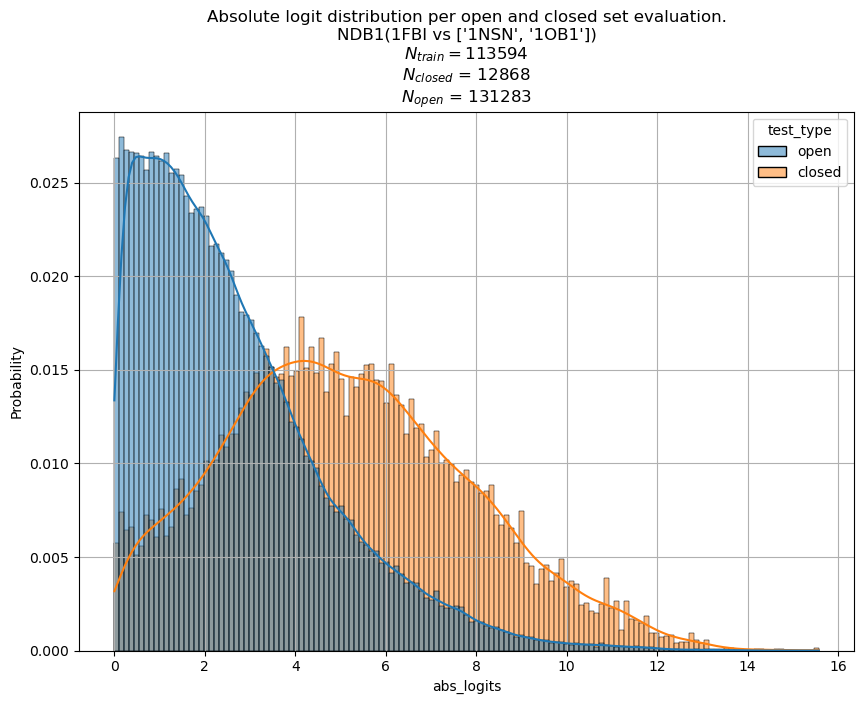

In [13]:
metadata={
    "ag_pos": ag_pos,
    "ag_neg": ag_neg,
    "N_train": len(train_loader.dataset),
    "N_closed": len(test_loader.dataset),
    "N_open": len(open_loader.dataset),
}

fig, ax = vis.plot_abs_logit_distr(
    eval_metrics, 
    metadata=metadata,
)
fig.show()

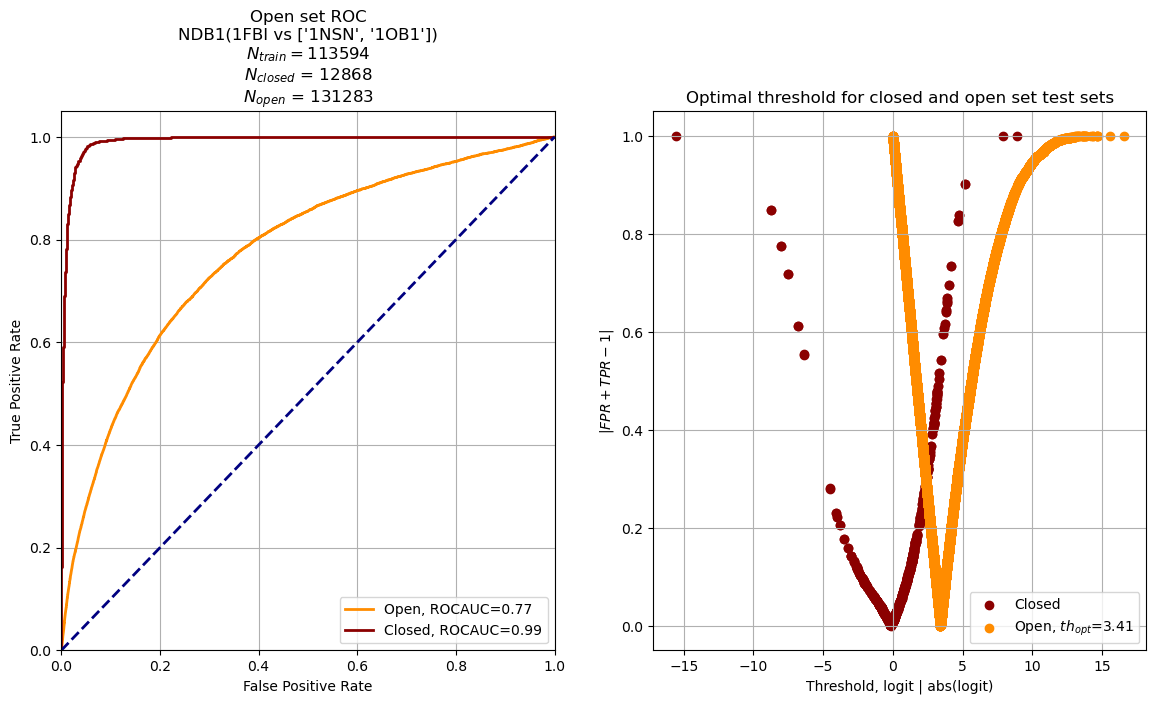

In [19]:
fig, _ = vis.plot_roc_open_and_closed_testsets(eval_metrics, metadata=metadata)
fig.show()

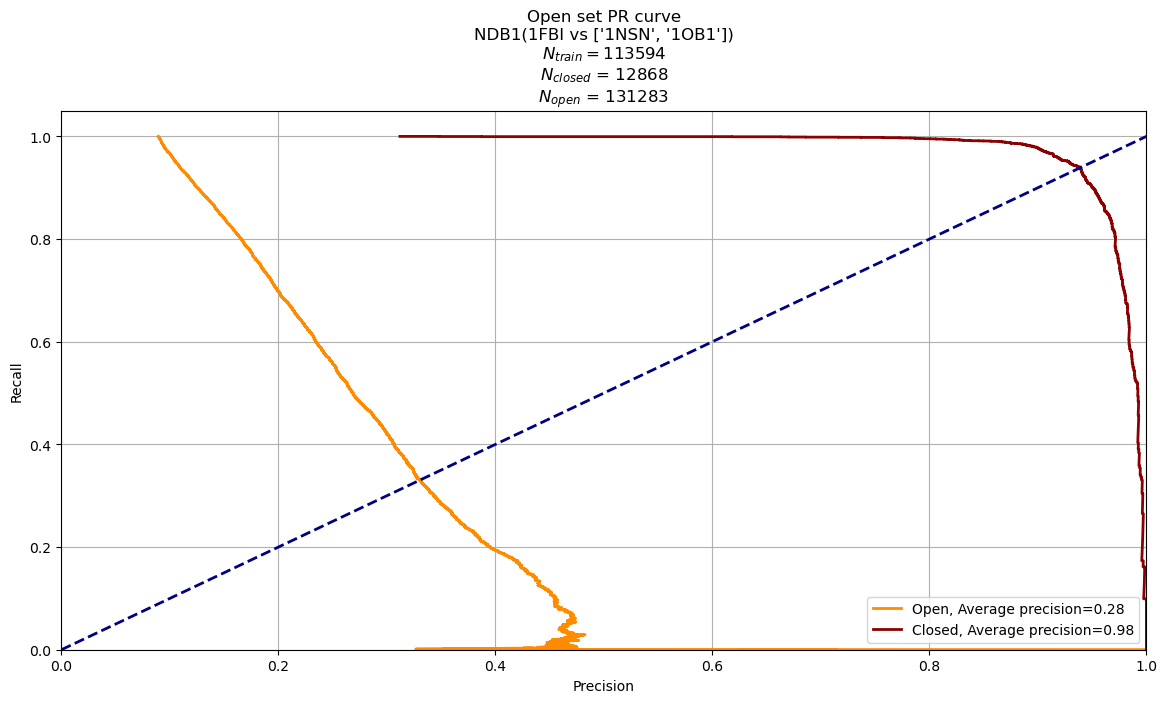

In [20]:
fig, _ = vis.plot_pr_open_and_closed_testsets(eval_metrics, metadata=metadata)
fig.show()

## Openset performance with optimal threshold

Here we have a short snippet to derive open set performance from mlflow logged data and then compute the open set recognition metrics.

For us it is more important to check the F1 score, precision and recall, since we are much more interested in the detection of closed-set examples:
- We optimize binary classification threshold based on F1 score
- We check the Precision-Recall curve, which is appropriate for imbalanced case, and it is intuitive.

In [2]:
artifacts_storage_dir = Path("../data/nco_mlflow_runs/ftp/artifacts_store")
run_id = "1b8ad99089814b2a87147c3fb32dd6f8"
experiment_id = "3"
eval_metrics_path = artifacts_storage_dir / experiment_id / run_id / "artifacts/eval_metrics.json"

with open(eval_metrics_path, "r") as fh:
    eval_metrics = json.load(fh)

In [3]:
abs_logits = np.array(eval_metrics["y_open_abs_logits"])
y_true = np.array(eval_metrics["y_open_true"])
assert len(abs_logits) == len(y_true) and type(abs_logits) == type(y_true) == np.ndarray

precision_open, recall_open, thresholds_open, th_open_opt = ml.compute_pr_curve(
    y_true,
    abs_logits,
)
f1_score = (2 * precision_open * recall_open) / (precision_open + recall_open + 1e-8)

y_pred = (abs_logits > th_open_opt).astype(np.int16)
ml.compute_binary_metrics(y_pred, y_true)

{'acc_closed': 0.9135027687065171,
 'recall_closed': 0.21311475409836064,
 'precision_closed': 0.3051278217969801,
 'f1_closed': 0.25095290790606173}

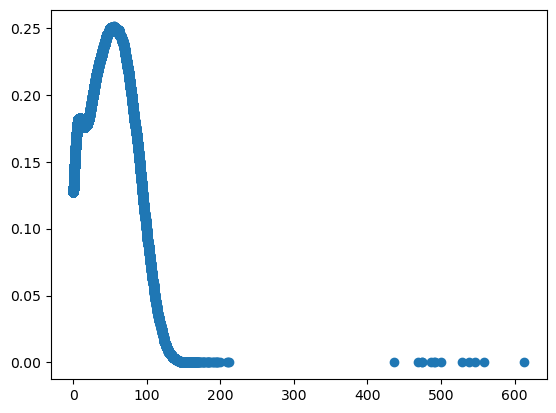

In [11]:
# Recall-precision curve
# plt.scatter(recall_open, precision_open)

# Optimal f1_score ~ threshold
plt.scatter(thresholds_open, f1_score[:-1])

## Hyperparameter optimization

We perform hyperparameter optimization:
- Epochs: 25. After fixing, do 100 epochs. Usually what performs early well will perform later as well.
- learning rates: [1e-3, 1]. Do LR range tests? If unsatisfactory results. How: increase learning rate linearly and slowly with epochs. Add cyclical policy?
- batch size: 128, 256, 512, 1024
- Momentum: 0.8-0.99. Add cyclical policy?
- weight decay: 1e-3, 1e-4, 1e-5, 0
- Optimizer: Adam is considered standard, but sometimes one requires SGD. Adam: requires less tuning, good generalization performance, we do only Adam.

We do it in `script_06b_*`, here we explore the interface.

In [27]:
def demo_objective(trial):
    x = trial.suggest_float("x", -10, 10)
    return (x - 2) ** 2

def demo_callback(study: optuna.study.Study, trial: optuna.trial.FrozenTrial) -> None:
    print(f"Print from callback: {study.trials_dataframe()}")

study = optuna.create_study(direction="minimize")
study.optimize(
    demo_objective, 
    n_trials=3, 
    n_jobs=1,
    callbacks=[demo_callback],
    );

# plots

[I 2022-09-13 15:50:14,566] A new study created in memory with name: no-name-947e7e84-d152-4e40-980e-7583a326cc36
[I 2022-09-13 15:50:14,570] Trial 0 finished with value: 48.15362348472922 and parameters: {'x': 8.939281193663305}. Best is trial 0 with value: 48.15362348472922.
[I 2022-09-13 15:50:14,579] Trial 1 finished with value: 18.421166628869482 and parameters: {'x': -2.291988656656665}. Best is trial 1 with value: 18.421166628869482.
[I 2022-09-13 15:50:14,585] Trial 2 finished with value: 35.688191360896944 and parameters: {'x': -3.9739594375001364}. Best is trial 1 with value: 18.421166628869482.


Print from callback:    number      value             datetime_start          datetime_complete  \
0       0  48.153623 2022-09-13 15:50:14.569347 2022-09-13 15:50:14.569922   

                duration  params_x     state  
0 0 days 00:00:00.000575  8.939281  COMPLETE  
Print from callback:    number      value             datetime_start          datetime_complete  \
0       0  48.153623 2022-09-13 15:50:14.569347 2022-09-13 15:50:14.569922   
1       1  18.421167 2022-09-13 15:50:14.579230 2022-09-13 15:50:14.579474   

                duration  params_x     state  
0 0 days 00:00:00.000575  8.939281  COMPLETE  
1 0 days 00:00:00.000244 -2.291989  COMPLETE  
Print from callback:    number      value             datetime_start          datetime_complete  \
0       0  48.153623 2022-09-13 15:50:14.569347 2022-09-13 15:50:14.569922   
1       1  18.421167 2022-09-13 15:50:14.579230 2022-09-13 15:50:14.579474   
2       2  35.688191 2022-09-13 15:50:14.585291 2022-09-13 15:50:14.585517  

In [28]:
study.trials_dataframe()
# study.sampler, study.pruner

,number,value,datetime_start,datetime_complete,duration,params_x,state
0,0,48.153623,2022-09-13 15:50:14.569347,2022-09-13 15:50:14.569922,0 days 00:00:00.000575,8.939281,COMPLETE
1,1,18.421167,2022-09-13 15:50:14.579230,2022-09-13 15:50:14.579474,0 days 00:00:00.000244,-2.291989,COMPLETE
2,2,35.688191,2022-09-13 15:50:14.585291,2022-09-13 15:50:14.585517,0 days 00:00:00.000226,-3.973959,COMPLETE


In [29]:
study.best_params

{'x': -2.291988656656665}